<a href="https://colab.research.google.com/github/Uwimbabazi-Keza/RSL-Project/blob/main/Rwandan_Sign_Language_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install tensorflow opencv-python mediapipe scikit-learn matplotlib tensorflowjs

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.1/36.1 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 33.2 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
  Attempting uninstall: tensorboard
    Found existing installation: 

In [2]:
import cv2
import numpy as np
import os
import time
import mediapipe as mp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import pickle

In [6]:
from google.colab import drive
drive.mount('/content/drive')
DATA_PATH = '/content/drive/MyDrive/RSL_Dataset'

Mounted at /content/drive


# Pre-process using OpenCV and MediaPipe

In [7]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

def draw_styled_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION,
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1))
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2))
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2))
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2))

def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

def flip_image(image):
  '''flipping image horizontally'''
  return cv2.flip(image, 1)

In [8]:
# Laod videos from subfolders within category folders
categories = ['Interuro', 'Inshinga', 'Inyuguti', 'Urabaza', 'Izina', 'Iminsi']
actions = []

for category in categories:
    category_path = os.path.join(DATA_PATH, category)
    if os.path.exists(category_path):
        subfolders = [subfolder for subfolder in os.listdir(category_path) if os.path.isdir(os.path.join(category_path, subfolder))]
        actions.extend(subfolders)

actions = np.array(sorted(set(actions)))

In [ ]:
# Ensures 30fps
no_sequences = 30
sequence_length = 30

def pad_sequence(sequence, target_length=30):
    if len(sequence) < target_length:
        padding = np.zeros((target_length - len(sequence), 1662))
        sequence = np.vstack((sequence, padding))
    elif len(sequence) > target_length:
        sequence = sequence[:target_length]
    return sequence

mp_holistic = mp.solutions.holistic

sequences, labels = [], []
label_map = {label: num for num, label in enumerate(actions)}

processed_videos = []
failed_videos = []

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    for action in actions:
        category_folder = [cat for cat in categories if os.path.exists(os.path.join(DATA_PATH, cat, action))]
        if category_folder:
            action_path = os.path.join(DATA_PATH, category_folder[0], action)
            videos = os.listdir(action_path)

            for video in videos:
                video_path = os.path.join(action_path, video)
                cap = cv2.VideoCapture(video_path)
                original_window = []
                flipped_window = []
                frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

                try:
                    for frame_num in range(min(sequence_length, frame_count)):
                        ret, frame = cap.read()
                        if not ret:
                            raise ValueError("Could not read frame.")

                        image, results = mediapipe_detection(frame, holistic)
                        draw_styled_landmarks(image, results)
                        keypoints = extract_keypoints(results)
                        original_window.append(keypoints)

                        flipped_frame = flip_image(frame)
                        flipped_image, flipped_results = mediapipe_detection(flipped_frame, holistic)
                        draw_styled_landmarks(flipped_image, flipped_results)
                        flipped_keypoints = extract_keypoints(flipped_results)
                        flipped_window.append(flipped_keypoints)

                    original_window = pad_sequence(np.array(original_window), sequence_length)
                    flipped_window = pad_sequence(np.array(flipped_window), sequence_length)

                    sequences.append(original_window)
                    labels.append(label_map[action])
                    sequences.append(flipped_window)
                    labels.append(label_map[action])

                    processed_videos.append(video_path)
                    print(f"Successfully processed video (original and flipped): {video_path}")

                except Exception as e:
                    failed_videos.append((video_path, str(e)))
                    print(f"Failed to process video: {video_path} - Error: {str(e)}")

                finally:
                    cap.release()

## Save data

In [ ]:
drive_path = '/content/drive/MyDrive/RSL_Data_Augmented'
os.makedirs(drive_path, exist_ok=True)
X = np.array(sequences)
y = np.array(labels)

np.save(X_save_path, X)
np.save(y_save_path, y)

with open(label_map_save_path, 'wb') as f:
    pickle.dump(label_map, f)
with open(sequences_save_path, 'wb') as f:
    pickle.dump(sequences, f)
with open(labels_save_path, 'wb') as f:
    pickle.dump(labels, f)

print(f"Features saved to: {X_save_path}")
print(f"Labels saved to: {y_save_path}")
print(f"Label map saved to: {label_map_save_path}")
print(f"Sequences saved to: {sequences_save_path}")
print(f"Labels (raw) saved to: {labels_save_path}")



Features saved to: /content/drive/MyDrive/RSL_Data_Augmented/X_data_augmented.npy
Labels saved to: /content/drive/MyDrive/RSL_Data_Augmented/y_data_augmented.npy
Label map saved to: /content/drive/MyDrive/RSL_Data_Augmented/label_map_augmented.pkl
Sequences saved to: /content/drive/MyDrive/RSL_Data_Augmented/sequences_augmented.pkl
Labels (raw) saved to: /content/drive/MyDrive/RSL_Data_Augmented/labels_augmented.pkl


In [9]:
# Load data
X = np.load('/content/drive/MyDrive/RSL_Data_Augmented/X_data_augmented.npy')
y = np.load('/content/drive/MyDrive/RSL_Data_Augmented/y_data_augmented.npy')

with open('/content/drive/MyDrive/RSL_Data_Augmented/label_map_augmented.pkl', 'rb') as f:
    label_map = pickle.load(f)

with open('/content/drive/MyDrive/RSL_Data_Augmented/sequences_augmented.pkl', 'rb') as f:
    sequences = pickle.load(f)

with open('/content/drive/MyDrive/RSL_Data_Augmented/labels_augmented.pkl', 'rb') as f:
    labels = pickle.load(f)

print("Data loaded successfully.")


Data loaded successfully.


In [10]:
#Basic Metrics and Consistency Check
total_sequences = len(sequences)
total_labels = len(labels)
unique_labels = len(set(labels))
print("Basic Data Quality Metrics:")
print(f"Total Sequences: {total_sequences}")
print(f"Total Labels: {total_labels}")
print(f"Unique Labels: {unique_labels}")
print(f"Matching Sequence and Label Counts: {total_sequences == total_labels}")


Basic Data Quality Metrics:
Total Sequences: 3000
Total Labels: 3000
Unique Labels: 50
Matching Sequence and Label Counts: True


In [ ]:
#Label Distribution Balance Check
unique, counts = np.unique(labels, return_counts=True)
print("\nLabel Distribution:")
for lbl, count in zip(unique, counts):
    print(f"Label {lbl} ({list(label_map.keys())[list(label_map.values()).index(lbl)]}): {count} samples")


Label Distribution:
Label 0 (A): 60 samples
Label 1 (Amafaranga): 60 samples
Label 2 (Amakuru yawe): 60 samples
Label 3 (Amata): 60 samples
Label 4 (B): 60 samples
Label 5 (C): 60 samples
Label 6 (D): 60 samples
Label 7 (E): 60 samples
Label 8 (F): 60 samples
Label 9 (G): 60 samples
Label 10 (Guhagarika): 60 samples
Label 11 (Gukunda): 60 samples
Label 12 (H): 60 samples
Label 13 (Hehe): 60 samples
Label 14 (Inde): 60 samples
Label 15 (Ishuli): 60 samples
Label 16 (J): 60 samples
Label 17 (K): 60 samples
Label 18 (Kugira): 60 samples
Label 19 (Kunywa): 60 samples
Label 20 (Kurya): 60 samples
Label 21 (L): 60 samples
Label 22 (M): 60 samples
Label 23 (Mfasha): 60 samples
Label 24 (Muraho): 60 samples
Label 25 (Murakoze): 60 samples
Label 26 (N): 60 samples
Label 27 (Ndashaka): 60 samples
Label 28 (Ni meza): 60 samples
Label 29 (Nitwa): 60 samples
Label 30 (Ntuye): 60 samples
Label 31 (O): 60 samples
Label 32 (P): 60 samples
Label 33 (Q): 60 samples
Label 34 (R): 60 samples
Label 35 (Rw

In [ ]:
#Keypoint Distribution Analysis
keypoints_mean = np.mean(X, axis=(0, 1))
keypoints_std = np.std(X, axis=(0, 1))
print("\nKeypoint Statistics:")
print(f"Mean of keypoints (per dimension): {keypoints_mean[:10]} (showing first 10 values)")
print(f"Standard Deviation of keypoints (per dimension): {keypoints_std[:10]} (showing first 10 values)")


Keypoint Statistics:
Mean of keypoints (per dimension): [ 0.49509773  0.40310997 -1.27559719  0.97681815  0.52836546  0.36398763
 -1.18537646  0.97635972  0.54918808  0.3651226 ] (showing first 10 values)
Standard Deviation of keypoints (per dimension): [0.09117009 0.13180258 0.91845206 0.14642208 0.09906443 0.13076216
 0.86270082 0.1463653  0.10565913 0.13073366] (showing first 10 values)


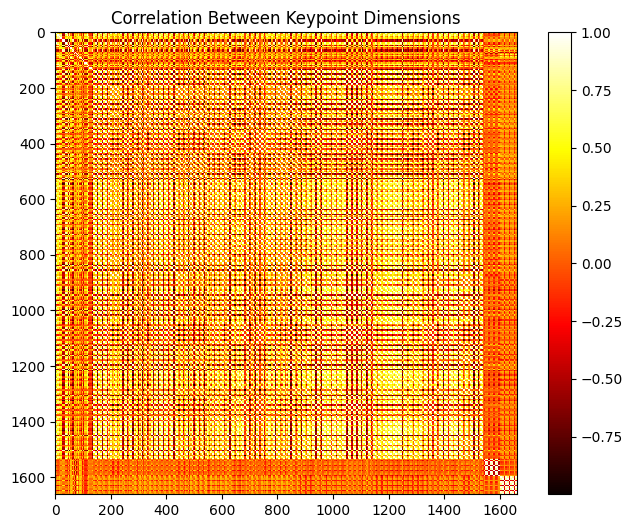

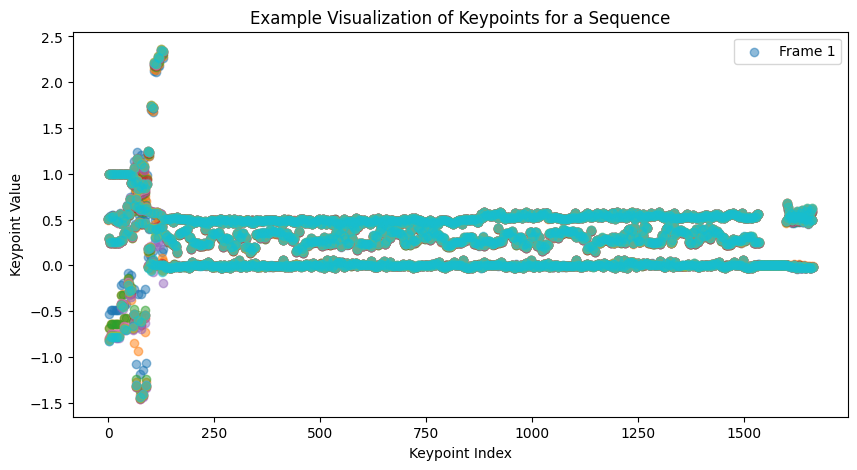

In [ ]:
#Visualize Correlation Between Keypoints (Optional)
if X.shape[2] >= 3:  # If keypoints have at least x, y, z
    keypoints_flat = X.reshape(-1, X.shape[-1])
    correlation_matrix = np.corrcoef(keypoints_flat, rowvar=False)
    plt.figure(figsize=(8, 6))
    plt.imshow(correlation_matrix, cmap='hot', interpolation='nearest')
    plt.title('Correlation Between Keypoint Dimensions')
    plt.colorbar()
    plt.show()

def visualize_sequence(sequence, title="Example Sequence Visualization"):
    plt.figure(figsize=(10, 5))
    for i, keypoints in enumerate(sequence[:10]):  # Plot first 10 frames as an example
        plt.scatter(range(len(keypoints)), keypoints, alpha=0.5, label=f'Frame {i+1}' if i < 1 else "")
    plt.title(title)
    plt.xlabel('Keypoint Index')
    plt.ylabel('Keypoint Value')
    plt.legend()
    plt.show()

if sequences:
    visualize_sequence(sequences[0], "Example Visualization of Keypoints for a Sequence")

# Train augmented data using LTSM

In [11]:
# Split sets and modify input shape due to the augmented data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
num_classes = 50

y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

print("New y_train shape:", y_train.shape)
print("New y_test shape:", y_test.shape)


New y_train shape: (2400, 50)
New y_test shape: (600, 50)


In [ ]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30, 1662)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(LSTM(128, return_sequences=False, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=2000,
                    batch_size=64,
                    callbacks=[tb_callback, early_stopping])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/2000
38/38 ━━━━━━━━━━━━━━━━━━━━ 23s 454ms/step - categorical_accuracy: 0.0141 - loss: 4.3127 - val_categorical_accuracy: 0.0250 - val_loss: 3.9113
Epoch 2/2000
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 236ms/step - categorical_accuracy: 0.0233 - loss: 4.0620 - val_categorical_accuracy: 0.0283 - val_loss: 3.9056
Epoch 3/2000
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 196ms/step - categorical_accuracy: 0.0505 - loss: 3.8780 - val_categorical_accuracy: 0.0400 - val_loss: 3.8872
Epoch 4/2000
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 173ms/step - categorical_accuracy: 0.0685 - loss: 3.7554 - val_categorical_accuracy: 0.0183 - val_loss: 3.8635
Epoch 5/2000
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 203ms/step - categorical_accuracy: 0.0811 - loss: 3.6447 - val_categorical_accuracy: 0.0633 - val_loss: 3.8469
Epoch 6/2000
38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 278ms/step - categorical_accuracy: 0.1015 - loss: 3.5966 - val_categorical_accuracy: 0.0667 - val_loss: 3.7753
Epoch 7/2000
38/38 ━━━━━━━━━━━━━━━━━━━━ 18s 203ms/step - categorical_acc

In [22]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                       │ (None, 30, 64)              │         442,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 30, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_13 (LSTM)                       │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 50)                  │           1,650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 553,684 (2.11 MB)

 Trainable params: 553,298 (2.11 MB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 2 (12.00 B)

In [ ]:
# Save best model
model.save('/content/drive/MyDrive/RSL_models/rsl_model_5.keras')
model.save('/content/drive/MyDrive/RSL_models/rsl_model_5.h5')


In [12]:
# Load best model
model_path = '/content/drive/My Drive/RSL_models/rsl_model_4.h5'
model = load_model(model_path)
print("Model loaded successfully.")

Model loaded successfully.


# Test and Evaluation

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step
Model Accuracy: 0.93

Classification Report:

              precision    recall  f1-score   support

           A       1.00      0.75      0.86        12
  Amafaranga       1.00      1.00      1.00        12
Amakuru yawe       1.00      0.92      0.96        12
       Amata       1.00      1.00      1.00        12
           B       0.91      0.83      0.87        12
           C       0.92      1.00      0.96        12
           D       0.85      0.92      0.88        12
           E       0.75      0.75      0.75        12
           F       1.00      1.00      1.00        12
           G       1.00      1.00      1.00        12
  Guhagarika       1.00      0.92      0.96        12
     Gukunda       1.00      1.00      1.00        12
           H       1.00      1.00      1.00        12
        Hehe       0.92      1.00      0.96        12
        Inde       1.00      0.83      0.91        12
      Ishuli       1.00      1.00      1.00      

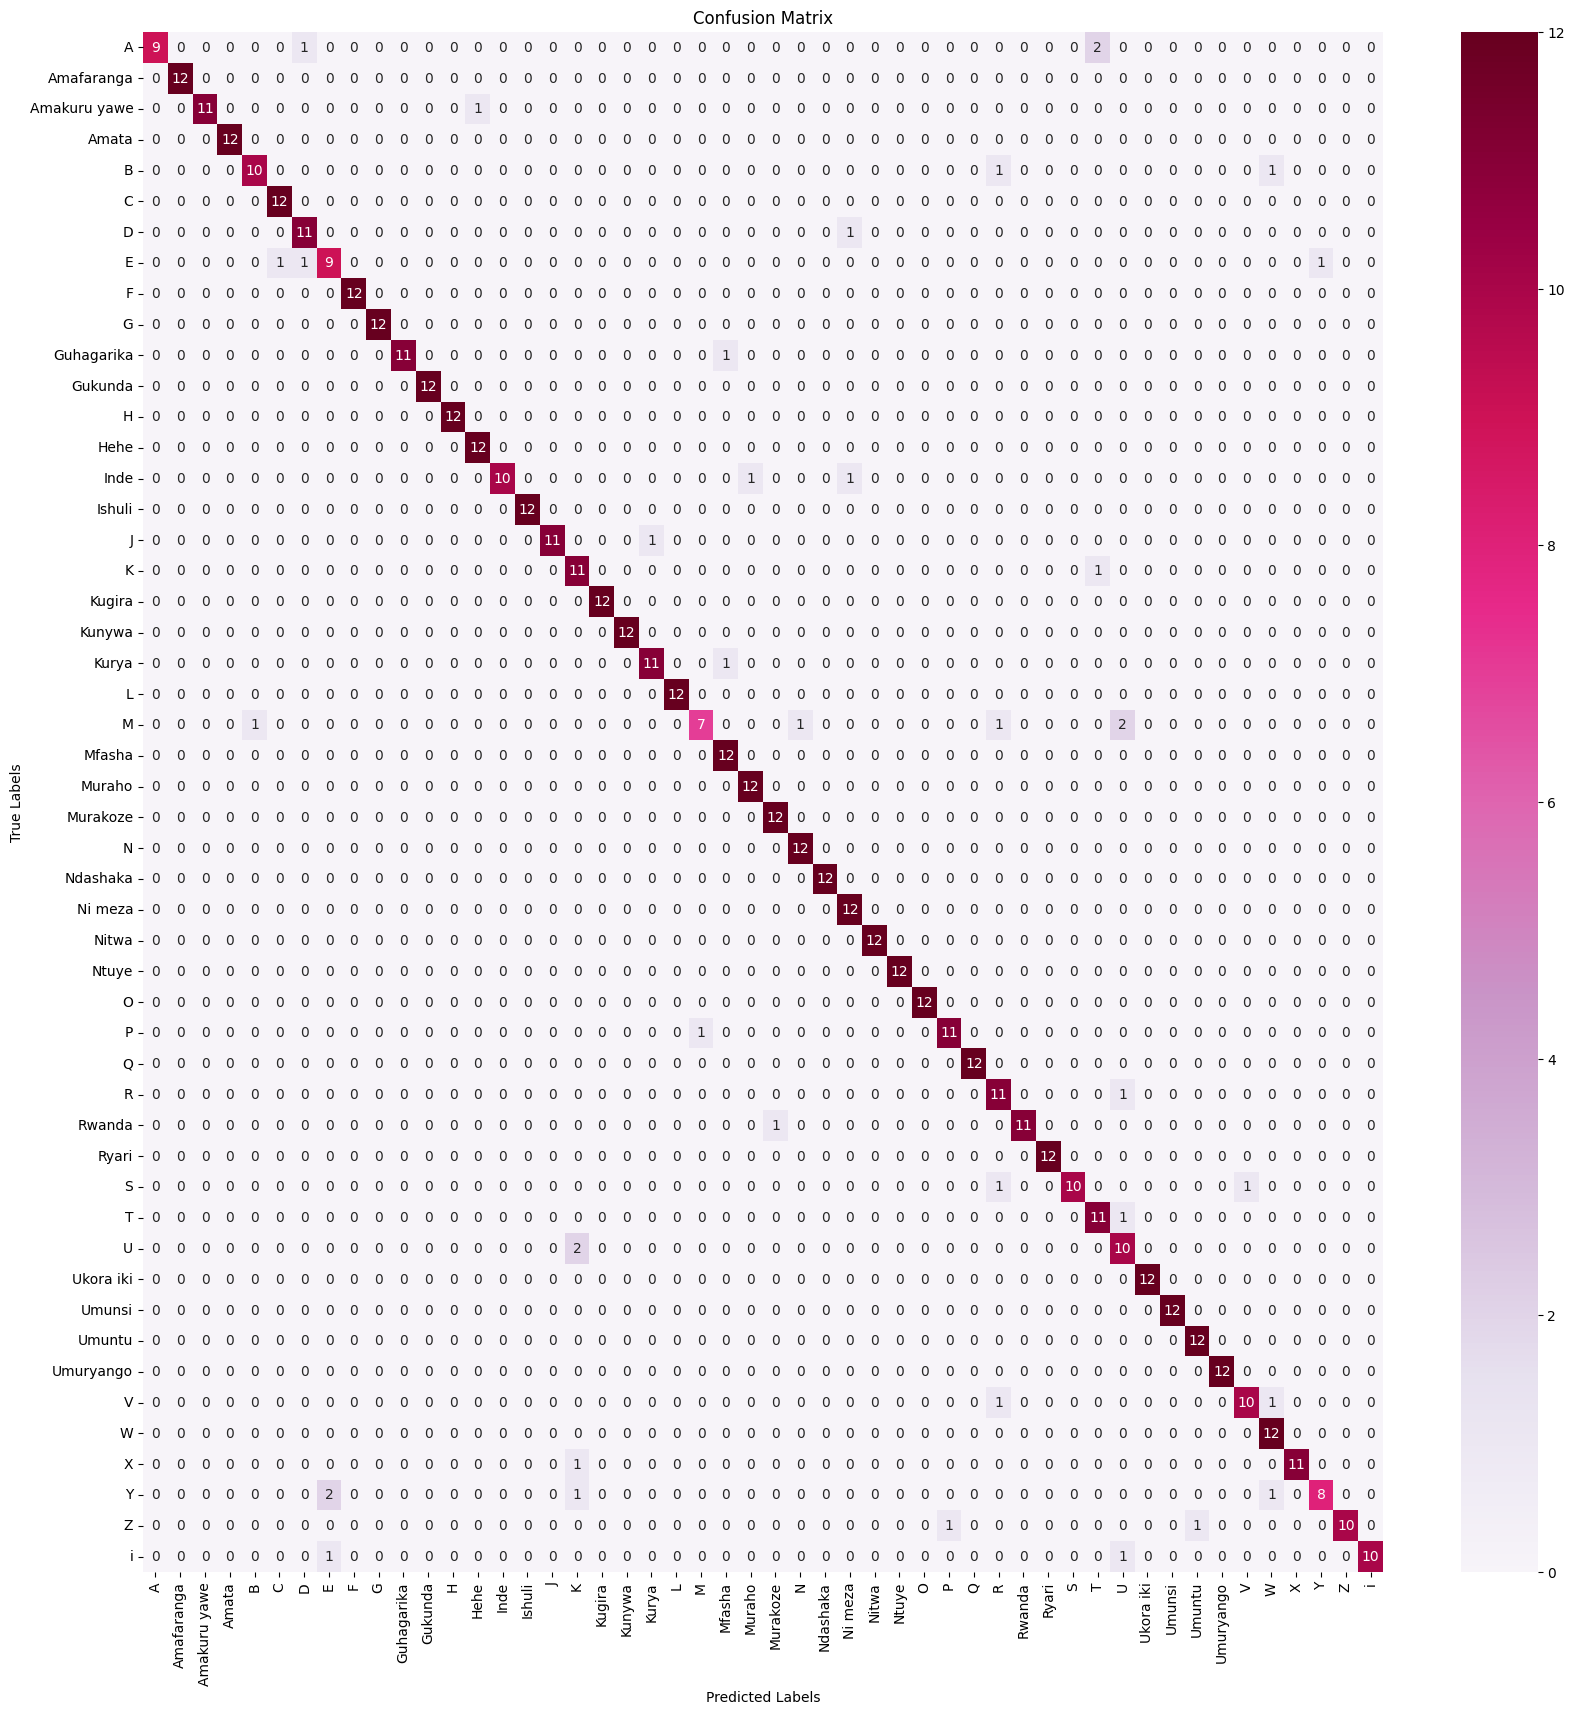

In [13]:
# Precision, Recall, F1 Score, Confusion Matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f"Model Accuracy: {accuracy:.2f}")

class_report = classification_report(y_true_classes, y_pred_classes, target_names=actions)
print("\nClassification Report:\n")
print(class_report)

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(20, 20))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='PuRd', xticklabels=actions, yticklabels=actions)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [14]:
# Test Accuracy
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Accuracy: 93.33%


In [15]:
# Top-k accuracy
import tensorflow as tf
top_k_accuracy = tf.keras.metrics.top_k_categorical_accuracy(y_test, y_pred, k=3)
print(f"Top-3 Accuracy: {tf.reduce_mean(top_k_accuracy).numpy() * 100:.2f}%")


Top-3 Accuracy: 98.17%


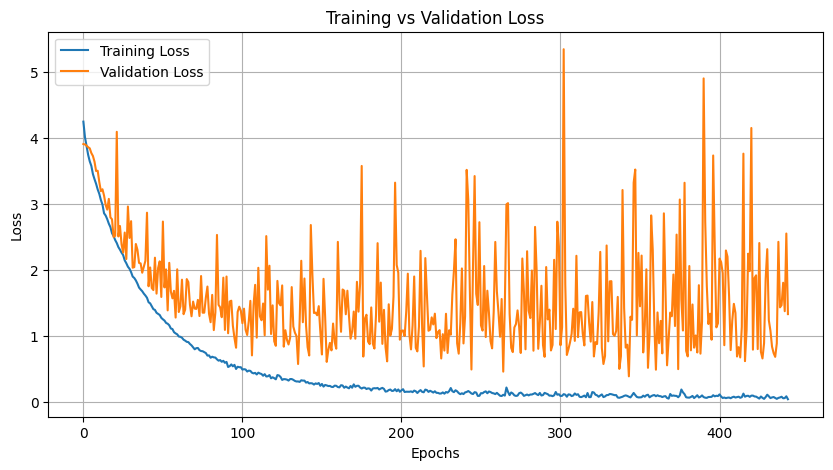

In [ ]:
# Training/Val loss
def plot_loss_curve(history):
    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']

    plt.figure(figsize=(10, 5))
    plt.plot(training_loss, label='Training Loss')
    plt.plot(validation_loss, label='Validation Loss')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss_curve(history)